# Defs and loads

In [1]:
import re
import sys
import json
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from google.transit import gtfs_realtime_pb2
root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 
from src.utils.time import (
    timestamp_to_hhmmss,
    timestamp_to_yyyymmdd_hhmmss,
    seconds_to_hhmmss,
    hhmmss_to_seconds,
    timestamp_to_seconds,
)

parent = Path('..','data')
dynamic_path = parent / 'dynamic_gtfs'
static_path = parent / 'static_gtfs'
pattern = re.compile(r"feed_(\d{8})_(\d{6})\.pb")

In [13]:
routes = pd.read_csv(static_path / 'routes.txt', sep=',', low_memory=False)
trips = pd.read_csv(static_path / 'trips.txt', sep=',', low_memory=False)
stop_times = pd.read_csv(static_path / 'stop_times.txt', sep=',', low_memory=False)
stop_times['arrival_time'] = stop_times['arrival_time'].apply(hhmmss_to_seconds)
bus_route_ids = list(routes[routes['route_type'] == 3]['route_id'])
print(f'{len(bus_route_ids)} / {len(routes)}')

def route_name_from_id(route_id,routes):
    return str(list(routes[routes['route_id'] == route_id]['route_short_name'])[0])

def route_id_from_name(route_name, routes):
    return str(list(routes[routes['route_short_name'] == route_name]['route_id'])[0])

def trip_ids_of_route(route_name, routes):
    route_id = route_id_from_name(route_name, routes)
    return trips[trips['route_id'] == route_id]['trip_id']

303 / 367


# Preprocess real time data

### Availability

try_001: 2025-10-08 13:18:03 - 2025-10-08 17:10:42 0 days 03:52:39 (gap in 60-99 s)
try_002: 2025-10-09 21:31:04 - 2025-10-11 14:27:43 1 days 16:56:39 (gap in 60-175 s)
try_003: 2025-10-13 22:19:49 - 2025-10-20 22:16:50 6 days 23:57:01 (gap in 60-455 s)
try_004: 2025-10-21 18:30:49 - 2025-10-24 18:34:32 3 days 00:03:43 (gap in 60-192 s)
try_005: 2025-10-24 22:38:59 - 2025-10-29 08:43:47 4 days 10:04:48 (gap in 22-308 s)


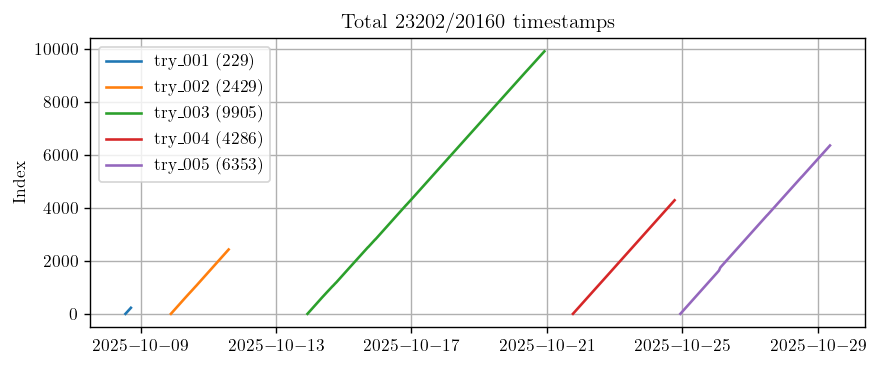

In [3]:
plt.figure(figsize=(8, 3),dpi=125)
count = 0
for folder in (dynamic_path / 'trials').iterdir():
    if folder.is_dir():
        timestamps = []
        for file in folder.iterdir():
            match = pattern.match(file.name)
            if match and  file.suffix == '.pb':
                date_str, time_str = match.groups()
                dt = pd.to_datetime(
                    date_str + time_str,
                    format="%Y%m%d%H%M%S"
                )
                timestamps.append(dt)  # only append if match is found
        
        timestamps = sorted(timestamps)
        count += len(timestamps)
        plt.plot(
            timestamps, range(len(timestamps)), '-', 
            label=f'{folder.name} ({len(timestamps)})'
        )

        deltas = [(t2 - t1).total_seconds() for t1, t2 in zip(timestamps[:-1], timestamps[1:])]
        min_gap = int(min(deltas))
        max_gap = int(max(deltas))

        print(
            f"{folder.name}: " 
            f"{timestamps[0]} - "
            f"{timestamps[-1]} "
            f"{timestamps[-1] - timestamps[0]} "
            f"(gap in {min_gap}-{max_gap} s)"
        )


plt.title(f"Total {count}/{24*60*14} timestamps")
plt.ylabel("Index")
plt.grid(True)
plt.legend()
plt.show()
# plt.savefig('time_steps.png')

### Organize into CSV/day

In [14]:
rows = []
prev_day_str = None

for folder in (dynamic_path / 'trials').iterdir():
    if not folder.is_dir():
        continue
    
    for file in tqdm(list(folder.iterdir()), desc=f'{folder.name}'):
        match = pattern.match(file.name)
        if not match or file.suffix != '.pb':
            continue
        
        # Which day?
        date_str, time_str = match.groups()
        dt = pd.to_datetime(date_str + time_str,format="%Y%m%d%H%M%S")
        day_str = dt.date().strftime("%Y%m%d")
        if (dynamic_path / 'records' / (day_str + ".csv")).exists():
            continue

        # Save the amount of rows, if the day changed
        if prev_day_str and prev_day_str != day_str and rows:
            csv_out = dynamic_path / 'records'/ (prev_day_str + ".csv")
            df = pd.DataFrame(rows)
            df.to_csv(csv_out, mode="w", header=not csv_out.exists(), index=False)
            rows = []
        prev_day_str = day_str

        # Load GTFS data
        feed = gtfs_realtime_pb2.FeedMessage()
        with open(file, "rb") as f:
            feed.ParseFromString(f.read())

        # Read and append GTFS data
        for vehicle in feed.entity:
            if vehicle.vehicle.trip.trip_id != '':
                
                route_id = vehicle.vehicle.trip.route_id
                
                # Append just the bus routes
                if route_id in bus_route_ids:
                    rows.append({
                        'id' : vehicle.id,
                        'trip_id' : vehicle.vehicle.trip.trip_id,
                        'scheduled' : vehicle.vehicle.trip.schedule_relationship,
                        'route_id' : vehicle.vehicle.trip.route_id,
                        'latitude' : vehicle.vehicle.position.latitude,
                        'longitude' : vehicle.vehicle.position.longitude,
                        'bearing' : vehicle.vehicle.position.bearing,
                        'speed' : vehicle.vehicle.position.speed,
                        'current_stop_sequence' : vehicle.vehicle.current_stop_sequence,
                        'current_status' : vehicle.vehicle.current_status,
                        'timestamp' : vehicle.vehicle.timestamp,
                        'stop_id' : vehicle.vehicle.stop_id,
                        'vehicle_id' : vehicle.vehicle.vehicle.id,
                        'label' : vehicle.vehicle.vehicle.label,
                        'license_plate' : vehicle.vehicle.vehicle.license_plate
                    })
        
# Save the last day's data      
if prev_day_str and rows:
    csv_out = dynamic_path / 'records'/ (prev_day_str + ".csv")
    df = pd.DataFrame(rows)
    df.to_csv(csv_out, mode="w", header=not csv_out.exists(), index=False)

try_005: 100%|██████████| 6354/6354 [00:22<00:00, 288.35it/s]


### Find disctint trips and calc them

In [19]:
occurance = {}
for csv_path in (dynamic_path / 'records').iterdir():
    trip_ids = pd.read_csv(csv_path, low_memory=False)['trip_id'].tolist()
    for trip_id in tqdm(trip_ids,desc=csv_path.name):
        if trip_id not in occurance.keys():
            occurance[trip_id] = 1
        else:
            occurance[trip_id] += 1
            # print(f'{trip_id} occured {occurance[trip_id]} times')

with open(dynamic_path / 'trip_occurance.json', 'w') as f:
    json.dump(occurance, f)

20251029.csv: 100%|██████████| 249560/249560 [00:00<00:00, 1037801.26it/s]


# Calculate delays (single day)

In [29]:
csv_path = dynamic_path / 'records' / '20251010.csv'
realtime = pd.read_csv(csv_path, low_memory=False)

### Single trip of a specific route

In [22]:
route_name = '53'

dynamic_trip_ids = set(realtime[realtime['route_id'] == route_id_from_name(route_name, routes)]['trip_id'].unique())
static_trip_ids  = set(trips[trips['trip_id'].isin(trip_ids_of_route(route_name, routes))]['trip_id'])

# How many incoming trip id is not included in the static set
uncovered_trip_ids = dynamic_trip_ids-static_trip_ids
covered_trip_ids = dynamic_trip_ids-uncovered_trip_ids

print(len(covered_trip_ids), len(uncovered_trip_ids))

list(covered_trip_ids)[:4]

196 0


['C967364412', 'C96736174', 'C96736226', 'C967364399']

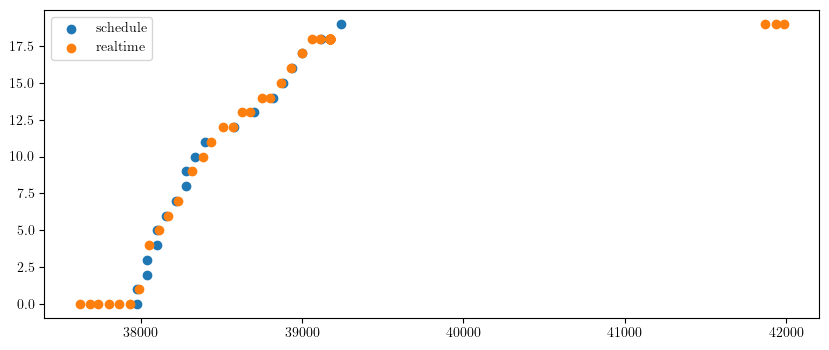

In [24]:
trip_id = 'C96736169'

# Single trip
dynamic = realtime[realtime['trip_id'] == trip_id].copy()# [['current_stop_sequence','timestamp']]
dynamic['time'] = dynamic['timestamp'].apply(timestamp_to_seconds)
dynamic = dynamic.sort_values(by=['current_stop_sequence','time'],ascending=[False,True])

static = stop_times[stop_times['trip_id'] == trip_id] # [['stop_sequence','arrival_time']]
static = static.sort_values(by='stop_sequence', ascending=False)

plt.figure(figsize=(10,4))
plt.scatter(static['arrival_time'], static['stop_sequence'],label='schedule')
plt.scatter(dynamic['time'], dynamic['current_stop_sequence'],label='realtime')
plt.legend()
plt.show()

### All trips of all routes

In [10]:
static = stop_times[['trip_id','stop_sequence','arrival_time']].copy()
realtime = realtime[['route_id','trip_id','current_stop_sequence','timestamp']]

static['arrival_time'] = static['arrival_time'].apply(hhmmss_to_seconds)
realtime['time'] = realtime['timestamp'].apply(timestamp_to_seconds)

In [11]:
# All distinct available and incoming trips
available_trip_ids = set(trips['trip_id'].unique())
incoming_trip_ids = set(realtime['trip_id'].unique())

# Determine known trips
unknown_trip_ids = incoming_trip_ids - available_trip_ids
known_trip_ids = incoming_trip_ids - unknown_trip_ids

# Observe only the known trips
realtime = realtime[realtime['trip_id'].isin(known_trip_ids)]
static = static[static['trip_id'].isin(known_trip_ids)]

In [20]:
rows = []
for route_id, group1 in tqdm(realtime.groupby('route_id'), desc="Routes"):
    for trip_id, realtime_trip in tqdm(group1.groupby('trip_id'), desc="Trips",leave=False):
        static_trip = static[static['trip_id'] == trip_id]

        first_stop = static_trip.loc[static_trip['stop_sequence'].idxmin()]
        last_stop = static_trip.loc[static_trip['stop_sequence'].idxmax()]
        stop_seq_sp, time_sch_sp = first_stop['stop_sequence'], first_stop['arrival_time']
        stop_seq_ep, time_sch_ep = last_stop['stop_sequence'], last_stop['arrival_time']
        
        
        tmp = realtime_trip[realtime_trip['current_stop_sequence'].isin([stop_seq_ep])]
        msg = f'{csv_path.name} - '

        if tmp.empty:
            msg += f"A {trip_id} útra nincs meg az infó, hogy mikor ért a végállomásra"
            pass
        else:
            time_ep = tmp['time'].min()
            delay = int(time_ep - time_sch_ep)
            if delay < -12*3600: delay += 24 * 3600

            msg += f"A {trip_id} út "
            msg += f'{seconds_to_hhmmss(delay)} késéssel' if delay > 0 else f'{seconds_to_hhmmss(-delay)} gyorsabban'
            msg += ' lett teljesítve'

            rows.append([route_id, trip_id, delay, time_sch_sp])
        
            # print(msg)

pd.DataFrame(
    rows, columns=['route_id','trip_id','delay', 'trip_start']
).to_csv(
    dynamic_path / 'delays' / csv_path.name, 
    index=False
)    

Routes:   0%|          | 0/271 [00:00<?, ?it/s]

Routes: 100%|██████████| 271/271 [11:50<00:00,  2.62s/it]


# Investigate the time scale

In [66]:
import numpy as np

distinct_times = np.empty(0,dtype=np.int32)

for csv_path in tqdm(list((dynamic_path / 'records').iterdir()), desc=csv_path.name):
    realtime = pd.read_csv(csv_path, low_memory=False)
    distinct_times = np.concatenate([distinct_times,realtime['timestamp'].unique()])

20251015.csv: 100%|██████████| 21/21 [00:52<00:00,  2.51s/it]


In [121]:
distinct_times = np.sort(distinct_times)


gaps = np.diff(distinct_times)
breaks = np.where(gaps > 60*60*2)[0]     # indices of gaps > 10 min

intervals = []
idxes = []
start = 0
for b in breaks:
    idxes.append((start,b))
    intervals.append((distinct_times[start], distinct_times[b]))   # VALUES, not indices
    start = b + 1

intervals.append((distinct_times[start], distinct_times[-1]))

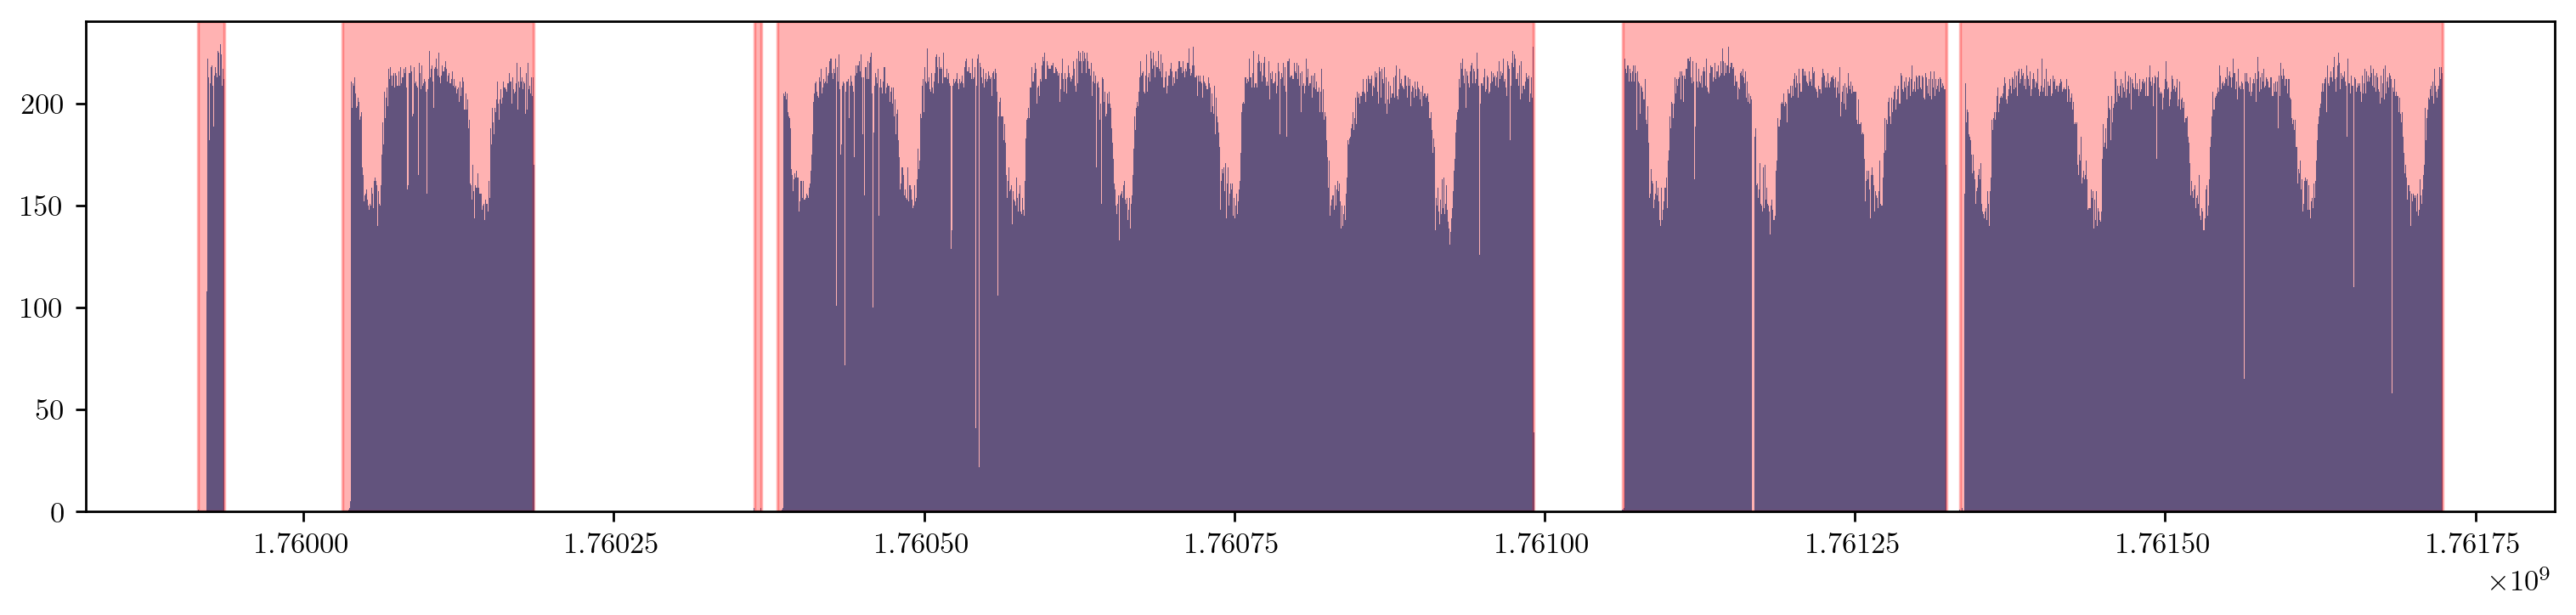

In [126]:
plt.figure(figsize=(15,3),dpi=250)
plt.hist(distinct_times,bins=5000)

for s, e in intervals:
    plt.axvspan(s, e, alpha=0.3, color='red')

plt.show()

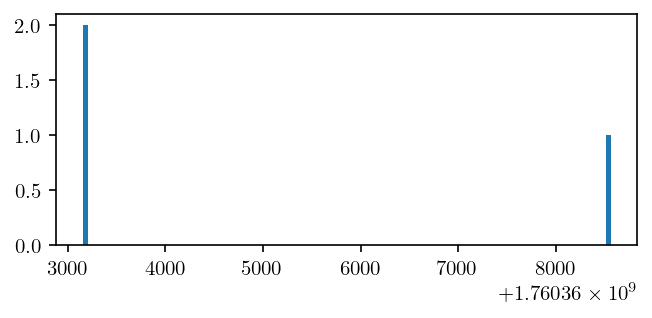

In [154]:
plt.figure(figsize=(5,2),dpi=150)
plt.hist(distinct_times[idxes[2][0]:idxes[2][1]],bins=100)
plt.show()

In [163]:
whole_time = np.array([e - s for s, e in intervals]).sum()
num_steps = len(distinct_times)

In [164]:
print(f'{whole_time / 60 / 60 // 24} days data and {num_steps} timestamps, results ~{whole_time/num_steps:.3f}s resolution')

16.0 days data and 767736 timestamps, results ~1.876s resolution


In [ ]:
n = 20000

print(f'{whole_time / 60 / 60 // 24} days data and {n} intervals, results ~{whole_time/n:.3f}s resolution')

16.0 days data and 20000 timestamps, results ~72.013s resolution
